In [1]:
#!/usr/bin/env python

from __future__ import print_function

try:
    import matplotlib
    matplotlib.use('Agg')
except ImportError:
    pass

import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions
from chainer import Variable
import numpy as np

In [2]:
class CorrNet(chainer.Chain):
    
    def __init__(self, n_units, in_size1, in_size2, c=0.2):
        super(CorrNet, self).__init__(
            enc1 = L.Linear(in_size1, n_units),  
            enc2 = L.Linear(in_size2,n_units), 
            enc_common = L.Linear(in_size1+in_size2, n_units),  
            dec1 = L.Linear(n_units, in_size1),
            dec2 = L.Linear(n_units, in_size2),
            dec_common = L.Linear(n_units, in_size1+in_size2),
        )
        self.c = c

        
    def __call__(self, x, y):
        h1 = self.enc1(x)
        rec1 = self.dec1(h1)
        loss1 = F.mean_squared_error(x, rec1)
        
        h2 = self.enc2(y)
        rec2 = self.dec2(h1)
        loss2 = F.mean_squared_error(y, rec2)
        
        xy = F.concat([x, y])
        h_common = self.enc_common(xy)
        rec_common = self.dec_common(h_common)
        loss3 = F.mean_squared_error(xy, rec_common)
            
        batch_size = h1.data.shape[0]
        
        corr = 0
        for one_h1, one_h2 in zip(h1.data, h2.data):
            corr += xp.corrcoef(one_h1, one_h2)[0][1]
        corr /= batch_size
        corr = abs(corr)
        corr = xp.array(corr, dtype=xp.float32)
        corr = Variable(corr, volatile=loss1.volatile)
        
        self.loss = loss1 + loss2 + loss3 - self.c * corr
        chainer.reporter.report({'loss': self.loss,
                                'loss1': loss1,
                                'loss2': loss2,
                                'loss3': loss3,
                                'corr': corr,
                                }, self)
        return self.loss
    
#     def enc1_dec1(self, x):
#         h = self.enc1(x)
#         return self.dec1(h)

#     def enc2_dec1(x):
#         h = self.enc2(x)
#         return self.dec1(h) 
    
#     def enc1_dec2(x):
#         h = self.enc1(x)
#         return self.dec2(h)
    
#     def enc2_dec2(x):
#         h = self.enc2(x)
#         return self.dec2(h) 

In [3]:
# def main():
#     parser = argparse.ArgumentParser(description='Chainer example: MNIST')
#     parser.add_argument('--batchsize', '-b', type=int, default=100,
#                         help='Number of images in each mini-batch')
#     parser.add_argument('--epoch', '-e', type=int, default=20,
#                         help='Number of sweeps over the dataset to train')
#     parser.add_argument('--frequency', '-f', type=int, default=-1,
#                         help='Frequency of taking a snapshot')
#     parser.add_argument('--gpu', '-g', type=int, default=-1,
#                         help='GPU ID (negative value indicates CPU)')
#     parser.add_argument('--out', '-o', default='result',
#                         help='Directory to output the result')
#     parser.add_argument('--resume', '-r', default='',
#                         help='Resume the training from snapshot')
#     parser.add_argument('--unit', '-u', type=int, default=1000,
#                         help='Number of units')
#     args = parser.parse_args()
import easydict
args = easydict.EasyDict({
        "batchsize": 100,
        "epoch": 20,
        "gpu": -1,
        "out": "CorrNN_Result",
        "resume": False,
        "unit": 20,
        "c": 0.5,
        "frequency": 100,
})


print('GPU: {}'.format(args.gpu))
print('# unit: {}'.format(args.unit))
print('# Minibatch-size: {}'.format(args.batchsize))
print('# epoch: {}'.format(args.epoch))
print('')

GPU: -1
# unit: 20
# Minibatch-size: 100
# epoch: 20



In [4]:
from chainer.datasets import tuple_dataset

def y_label2one_hot(tupled_data):
    x_list, y_list = [], []

    for i in range(len(tupled_data)):
        one_train = list(tupled_data[i])
        label = one_train[1]

        one_hot = np.zeros(10)
        one_hot[label] =1

        x_list.append(one_train[0])
        y_list.append(one_hot.astype(np.float32))
        
    return tuple_dataset.TupleDataset(x_list, y_list)

In [5]:
# Set up a neural network to train
# Classifier reports softmax cross entropy loss and accuracy at every
# iteration, which will be used by the PrintReport extension below.
#     model = L.Classifier(MLP(args.unit, 10))
model = CorrNet(args.unit, 784, 10, c=args.c)

if args.gpu >= 0:
    chainer.cuda.get_device(args.gpu).use()  # Make a specified GPU current
    model.to_gpu()  # Copy the model to the GPU

# Setup an optimizer
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

# Load the MNIST dataset
train, test = chainer.datasets.get_mnist()

train = y_label2one_hot(train)
test = y_label2one_hot(test)

train_iter = chainer.iterators.SerialIterator(train, args.batchsize)
test_iter = chainer.iterators.SerialIterator(test, args.batchsize,
                                             repeat=False, shuffle=False)

In [6]:
# Set up a trainer
updater = training.StandardUpdater(train_iter, optimizer, device=args.gpu)
trainer = training.Trainer(updater, (args.epoch, 'epoch'), out=args.out)

# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model, device=args.gpu))

# Dump a computational graph from 'loss' variable at the first iteration
# The "main" refers to the target link of the "main" optimizer.
trainer.extend(extensions.dump_graph('main/loss'))

# Take a snapshot for each specified epoch
frequency = args.epoch if args.frequency == -1 else max(1, args.frequency)
trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# Save two plot images to the result dir
#     if extensions.PlotReport.available():
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# Print selected entries of the log to stdout
# Here "main" refers to the target link of the "main" optimizer again, and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the Classifier link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# # Print a progress bar to stdout
# trainer.extend(extensions.ProgressBar())

if args.resume:
    # Resume from a snapshot
    chainer.serializers.load_npz(args.resume, trainer)
    
from chainer import cuda
xp = cuda.cupy if args.gpu >= 0 else np
# Run the training
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.0984639   0.034038                                                       8.2409        
2           0.0272871   0.0210357                                                      16.8274       
3           0.0196926   0.016388                                                       25.3544       
4           0.0177447   0.014701                                                       33.9436       
5           0.0181635   0.0153101                                                      42.5318       
6           0.019706    0.0175822                                                      51.076        
7           0.0211667   0.0159929                                                      60.3607       
8           0.0229097   0.0234194                                                      71.0576       
9           0.0252714   0.01983                                                     

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

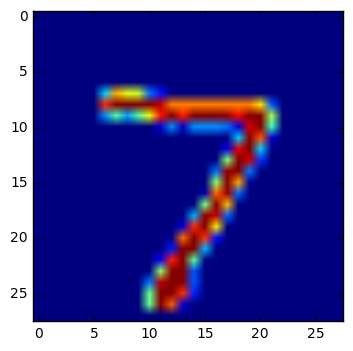

In [8]:
test_id = 0

## original
img = test[test_id][0].reshape([28,28])

plt.imshow(img)

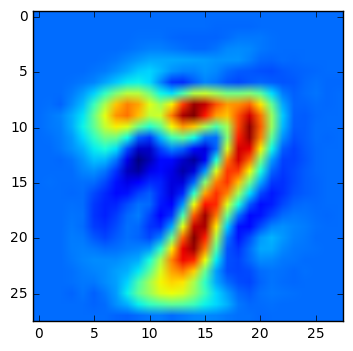

In [9]:
## reconstructed
sample = Variable(test[test_id][0][np.newaxis,: ])

rec = model.dec1(model.enc1(sample)).data
rec = rec.reshape([28,28])
plt.imshow(rec)

In [10]:
rec_label = model.dec2(model.enc1(sample)).data

print (rec_label[0],  ", predicted label is ", np.argmax(rec_label[0]))

[ 0.03220668 -0.00308897  0.11463334  0.07817318 -0.10950528 -0.02680297
 -0.00672571  0.95769733 -0.07544196  0.04566497] , predicted label is  7


ラベルの推定は正しくできている模様

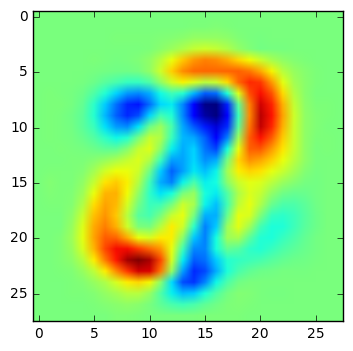

In [11]:
sample_label =  test[test_id][1][np.newaxis,: ]

rec_img = model.dec1(model.enc2(sample_label)).data

rec_img = rec_img.reshape([28,28])
plt.imshow(rec_img)

ラベルからのimg復元はなんとなくできてる...?

### ラベル0で復元してみる

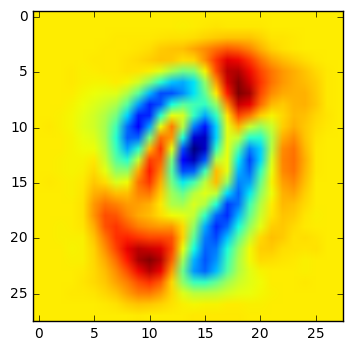

In [12]:
sample_label =  np.array([1,0,0,0,0,0,0,0,0,0])[np.newaxis,: ].astype(np.float32)

rec_img = model.dec1(model.enc2(sample_label)).data

rec_img = rec_img.reshape([28,28])
plt.imshow(rec_img)

うまく行っていない模様...

### 最後にconcatしたものの復元後のimgを確認

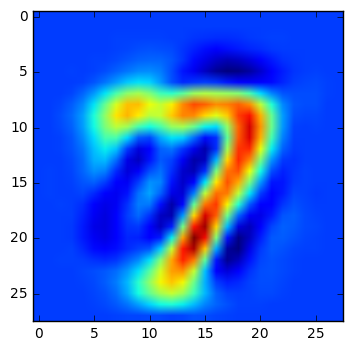

In [13]:
concat = np.concatenate([test[test_id][0], test[test_id][1]])[np.newaxis, :]

rec = model.dec_common(model.enc_common(concat))
rec = rec.data[0][:784].reshape([28,28])
plt.imshow(rec)

これはうまく復元できているようだ


以上